In [2]:
import argparse
import logging
import time

import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer, ngrams_iterator
from torchtext.datasets import DATASETS
from torchtext.utils import download_from_url
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import FastText, CharNGram
from tqdm import tqdm

### Information
- torchtext repo: https://github.com/pytorch/text/tree/main/torchtext
- torchtext documentation: https://pytorch.org/text/stable/index.html

### Constants

In [3]:
DATASET = "AG_NEWS"
DATA_DIR = ".data"
DEVICE = "cpu"
EMBED_DIM = 300
LR = 4.0
BATCH_SIZE = 16
NUM_EPOCHS = 5
PADDING_VALUE = 0
PADDING_IDX = PADDING_VALUE

### Get the tokenizer
- Use the WordLevel tokenizer.


In [7]:
basic_english_tokenizer = get_tokenizer("basic_english")

In [8]:
basic_english_tokenizer("This is some text ...")

['this', 'is', 'some', 'text', '.', '.', '.']

In [9]:
# Needed later.
TOKENIZER = basic_english_tokenizer

### Get the data and get the vocabulary

In [10]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield TOKENIZER(text)

In [11]:
train_iter = DATASETS[DATASET](root=DATA_DIR, split="train")
VOCAB = build_vocab_from_iterator(yield_tokens(train_iter), specials=('<pad>', '<unk>'))

# Make the default index the same as that of the unk_token.
VOCAB.set_default_index(VOCAB['<unk>'])

### Get FastText embeddings

In [12]:
FAST_TEXT = FastText("simple")
CHAR_N_GRAM = CharNGram()

In [13]:
CHAR_N_GRAM['man']

tensor([[-0.0543, -0.4330, -0.2278,  0.6375,  0.0610, -0.8325,  0.0874, -0.4586,
         -0.7087,  0.4219, -0.0781, -0.4513,  0.1864, -0.2689, -0.1786,  0.2056,
          0.1581,  0.0448, -0.2772, -0.7386,  0.1957, -0.4169, -0.0797,  0.3765,
          0.2585,  0.1417,  0.0207, -0.6438, -0.4622,  0.2307,  0.3223, -0.1761,
          0.2544,  0.4735,  0.2383, -0.3133,  1.0755,  0.2499,  0.0616,  0.3977,
         -0.0487,  0.1020,  0.0147,  0.4667,  0.1121,  0.3120,  0.1451,  0.2885,
          0.0230, -0.0647,  0.2310,  0.1558,  0.2476,  0.1358, -0.2032,  0.2636,
          0.6579, -0.0523, -0.0590,  0.1571,  0.0361, -0.2918, -0.0838, -0.5014,
          0.0208,  0.3744, -0.2141,  0.2901,  0.3321, -0.0112,  0.3000, -0.3634,
         -0.2557,  0.5706,  0.0784,  0.6650,  0.1114, -0.1816, -0.0394,  0.5677,
         -0.1042,  0.5530, -0.7118,  0.4389,  0.2508,  0.1046,  0.5798, -0.1003,
         -0.0708, -0.1352,  0.4329,  0.2213, -0.1554,  0.9490, -0.1002,  0.6771,
         -0.7881, -0.1341,  

In [14]:
FAST_TEXT['man'], FAST_TEXT['man']

(tensor([-0.1389,  0.0190,  0.1300, -0.3393, -0.1166,  0.2909, -0.2559, -0.0193,
          0.1188,  0.0866,  0.3076, -0.0333, -0.3238,  0.1477, -0.2113, -0.2862,
          0.2704,  0.0754,  0.2386, -0.2159,  0.1099,  0.1459,  0.1726, -0.3756,
         -0.3500, -0.3113,  0.1104, -0.5120,  0.2563,  0.1635, -0.4571,  0.0609,
          0.0517,  0.4809,  0.3148, -0.0945,  0.3150,  0.0511, -0.2391,  0.1846,
         -0.2133,  0.2519,  0.3127, -0.0041,  0.0205, -0.1369, -0.0269, -0.1088,
         -0.1341,  0.2618,  0.1766,  0.1638, -0.5062,  0.0328,  0.0753, -0.0485,
          0.5731,  0.2772,  0.1343, -0.1225, -0.2751,  0.1408, -0.0154,  0.0024,
         -0.3018, -0.2572, -0.2501, -0.0120, -0.2743, -0.0858,  0.0225,  0.2362,
         -0.0613,  0.1203, -0.0055,  0.1486, -0.1279, -0.2788, -0.1271,  0.3363,
         -0.2112, -0.0423, -0.3752, -0.1307, -0.1663,  0.2354, -0.3294, -0.0532,
         -0.3936,  0.0267, -0.5904, -0.0500, -0.0991,  0.2069,  0.1953, -0.3192,
         -0.0588,  0.3578, -

In [15]:
len(FAST_TEXT), FAST_TEXT.vectors.shape

(111051, torch.Size([111051, 300]))

In [16]:
len(CHAR_N_GRAM), CHAR_N_GRAM.vectors.shape

(874474, torch.Size([874474, 100]))

### Helper functions

In [17]:
def text_pipeline(text):
    return VOCAB(TOKENIZER(text))

def label_pipeline(label):
    return int(label) - 1

Nice link on collate_fn and DataLoader in PyTorch: https://python.plainenglish.io/understanding-collate-fn-in-pytorch-f9d1742647d3

In [18]:
# What does this do?
# How can this be improved?
def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        # Get the label from {1, 2, 3, 4} to {0, 1, 2, 3}
        label_list.append(label_pipeline(_label))
                
        # Return a list of ints.
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text.clone().detach())
    
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)
            
    return label_list.to(DEVICE), text_list.to(DEVICE)

### Get the data

In [19]:
train_iter = DATASETS[DATASET](root=DATA_DIR, split="train")
num_class = len(set([label for (label, _) in train_iter]))
# What are the classes?
print(f"The number of classes is {num_class} ...")

The number of classes is 4 ...


### Set up the model

Good reference on this type of model
- CNN for Sentence Classification: https://arxiv.org/pdf/1408.5882.pdf

You can build CNN models with either CNN1d or CNN2d.

In [20]:
# Data is of 128 word vector dimension and contains 10 words.
fake_sentence = torch.rand(128, 10)

# The number of word vector dimensions is 128.
# Output dimension is 1 X 9 as there is 1 kernel that slides across and the kernel size is 2.
# There is no padding here.
print(nn.Conv1d(128, 1, 2)(fake_sentence).shape)

# This is the same as above. There is 1 channel as this is text.
# Output dimension is 1 X 1 X 9 as there is 1 kernel that slides across and the kernel size is 128 X 2.
# The box dimension is 1 X 128 X 10, we've inserted a dimension of 1.
print(nn.Conv2d(1, 1, (128, 2))(fake_sentence.unsqueeze(0)).shape)

torch.Size([1, 9])
torch.Size([1, 1, 9])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


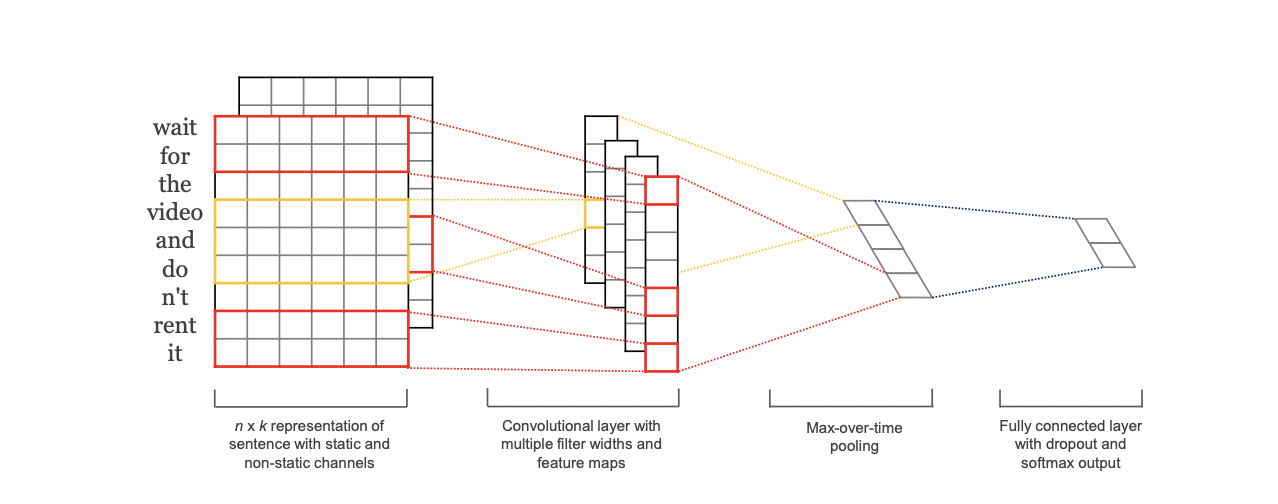

In [51]:
# If you want to use the CharNGram 100 dimensional embeddings, you need to modif the below code.
class CNN1dTextClassificationModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_class,
        embed_dim = 300, 
        use_pretrained = True,
        fine_tune_embeddings = True
    ):
        
        super(CNN1dTextClassificationModel, self).__init__()
        
        self.embedding = nn.Embedding(
            vocab_size,
            embed_dim,
            padding_idx=PADDING_IDX
        )
        
        if use_pretrained:
            self.embedding.weight.requires_grad = False
            for i in range(vocab_size):
                token = VOCAB.lookup_token(i)
                                
                self.embedding.weight[i, :] = FAST_TEXT.get_vecs_by_tokens(
                    token, 
                    lower_case_backup=True
                )
            self.embedding.weight.requires_grad = True
        else:
            self.init_weights()
                
        if not fine_tune_embeddings:
            self.embedding.weight.requires_grad = False
        
        
        self.cnn2 = nn.Conv1d(embed_dim, 1, 2)
        self.cnn3 = nn.Conv1d(embed_dim, 1, 3)
        self.cnn4 = nn.Conv1d(embed_dim, 1, 4)
        
        self.fc = nn.Linear(3, num_class)
        
        # For drop out + ReLu, order does not matter.
        self.dropout = nn.Dropout(0.3)
        
        # Set to True at first, then set to False.
        self.debug = True
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    # N = batch_size, L = sequence length, D = embed_dim
    def forward(self, text):
        
        # N X L X embed_dim
        embedded = self.embedding(text)
        
        if self.debug:
            print('embedding', embedded.shape)
        
        # N X embed_dim X L
        embedded = embedded.transpose(1, 2)
        
        # N X 1 X L - 1
        cnn2 = nn.ReLU()(self.cnn2(embedded))
        if self.debug:
            print('cnn2', cnn2.shape)
        
        # N X 1 X L - 2
        cnn3 = nn.ReLU()(self.cnn3(embedded))
        if self.debug:
            print('cnn3', cnn3.shape)
        
        # B X 1 X L - 3
        cnn4 = nn.ReLU()(self.cnn4(embedded))
        if self.debug:
            print('cnn4', cnn4.shape)
        
        # N X 1 in all cases.
        cnn2 = nn.MaxPool1d(cnn2.size(-1))(cnn2)
        cnn3 = nn.MaxPool1d(cnn3.size(-1))(cnn3)
        cnn4 = nn.MaxPool1d(cnn4.size(-1))(cnn4)
        if self.debug:
            print('cnn2 after max', cnn2.shape)
        
        # N X 3
        cnn_concat = self.dropout(
            torch.cat((cnn2.squeeze(1), cnn3.squeeze(1), cnn4.squeeze(1)), -1)
        )
        if self.debug:
            print('cnn concat', cnn_concat.shape)
                        
        out = self.fc(cnn_concat)
        
        # Set this to False after going through one batch od data.
        self.debug = False
        
        return out
    
# If you want to use the CharNGram 100 dimensional embeddings, you need to modif the below code.
# For CNN2d the data should be of shape B X 1 X D X L instead of B X D X L .
# This is since the "channel" is 1 dimensional.
class CNN2dTextClassificationModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_class,
        embed_dim = 300, 
        use_pretrained = True,
        fine_tune_embeddings = True
    ):
        
        super(CNN2dTextClassificationModel, self).__init__()
        
        self.embedding = nn.Embedding(
            vocab_size,
            embed_dim,
            padding_idx=PADDING_IDX
        )
        
        if use_pretrained:
            self.embedding.weight.requires_grad = False
            for i in range(vocab_size):
                token = VOCAB.lookup_token(i)
                
                print(token, TOKENIZER(token))
                
                self.embedding.weight[i, :] = FAST_TEXT.get_vecs_by_tokens(
                    TOKENIZER(token), 
                    lower_case_backup=True
                )
            self.embedding.weight.requires_grad = True
        else:
            self.init_weights()
                
        if not fine_tune_embeddings:
            self.embedding.weight.requires_grad = False
        
        # In C X H X W "image", we have C = 1, H = embed_dim, W = k for text.
        # We can also swap H and W but this is to make this "look" like the case when we do 1d convolutions.
        self.convs = [
            nn.Conv2d(1, 1, (embed_dim, 2)),
            nn.Conv2d(1, 1, (embed_dim, 3)),
            nn.Conv2d(1, 1, (embed_dim, 4))
        ]
        
        self.fc = nn.Linear(3, num_class)
        
        # For drop out + ReLu, order does not matter.
        self.dropout = nn.Dropout(0.3)
        
        self.debug = True
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    # B = batch_size, L = sequence length, D = vector dimension
    def forward(self, text):
        # text is originally B X L
        
        # N X L X embed_dim
        embedded = self.embedding(text)
        
        if self.debug:
            print('embedded ', embedded.shape)
        
        # N X embed_dim X L
        embedded = embedded.transpose(1, 2)
        
        if self.debug:
            print('embedded ', embedded.shape)
                    
        convs = [
            # This is N X 1 X (L - k + 1), where k is the filter size.
            # We need to add a dimension to "embedded".
            nn.ReLU()(conv(embedded.unsqueeze(1))) for  conv in self.convs
        ]
        
        if self.debug:
            print('conv ', [conv.shape for conv in convs])
        
        # Across all time steps. This is a list ad each is dimension 3.
        maxes = [
            nn.MaxPool2d((1, conv.size(-1)))(conv).squeeze() for conv in convs
        ]
        
        if self.debug:
            print('max ', [conv_max.shape for conv_max in maxes])
        
        # N X 3
        maxes_stack = self.dropout(
            torch.vstack(maxes).t()
        )
        
        if self.debug:
            print('max_stack ', maxes_stack.shape)
            
                        
        out = self.fc(maxes_stack)
        
        # Set to False after the first batch goes through.
        self.debug = False
        
        return out

### Set up the model

In [52]:
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
model1 = CNN1dTextClassificationModel(
    len(VOCAB),
    num_class
).to(DEVICE)

model2 = CNN2dTextClassificationModel(
    len(VOCAB),
    num_class
).to(DEVICE)

<pad> ['<pad>']
<unk> ['<unk>']
. ['.']
the ['the']
, [',']
to ['to']
a ['a']
of ['of']
in ['in']
and ['and']
s ['s']
on ['on']
for ['for']
#39 ['#39']
( ['(']
) [')']
- ['-']
' ["'"]
that ['that']
with ['with']
as ['as']
at ['at']
is ['is']
its ['its']
new ['new']
by ['by']
it ['it']
said ['said']
reuters ['reuters']
has ['has']
from ['from']
an ['an']
ap ['ap']
his ['his']
will ['will']
after ['after']
was ['was']
us ['us']
be ['be']
over ['over']
have ['have']
their ['their']
&lt ['&lt']
are ['are']
up ['up']
quot ['quot']
but ['but']
more ['more']
first ['first']
two ['two']
he ['he']
world ['world']
u ['u']
this ['this']
-- ['--']
company ['company']
monday ['monday']
wednesday ['wednesday']
tuesday ['tuesday']
oil ['oil']
out ['out']
thursday ['thursday']
one ['one']
not ['not']
against ['against']
inc ['inc']
friday ['friday']
into ['into']
they ['they']
about ['about']
last ['last']
iraq ['iraq']
year ['year']
than ['than']
york ['york']
yesterday ['yesterday']
who ['who']
pres

testers ['testers']
ticker=ko ['ticker=ko']
titanic ['titanic']
tn ['tn']
toast ['toast']
tolerance ['tolerance']
tomlinson ['tomlinson']
tongue ['tongue']
transcript ['transcript']
tribe ['tribe']
triggers ['triggers']
tsvangirai ['tsvangirai']
tucked ['tucked']
ulster ['ulster']
unfazed ['unfazed']
unsafe ['unsafe']
unwelcome ['unwelcome']
upi ['upi']
upright ['upright']
uproar ['uproar']
val ['val']
vanish ['vanish']
ventura ['ventura']
vertical ['vertical']
vna ['vna']
vying ['vying']
walsh ['walsh']
wares ['wares']
wartime ['wartime']
weakest ['weakest']
wong ['wong']
wrongly ['wrongly']
wsj ['wsj']
xaverian ['xaverian']
xavier ['xavier']
yours ['yours']
zhang ['zhang']
#8212 ['#8212']
17-10 ['17-10']
175 ['175']
2005-06 ['2005-06']
200m ['200m']
24-14 ['24-14']
40th ['40th']
500m ['500m']
765 ['765']
7bn ['7bn']
8-1 ['8-1']
90s ['90s']
990 ['990']
aa ['aa']
ablaze ['ablaze']
accessories ['accessories']
accompanied ['accompanied']
accountability ['accountability']
acquittal ['acqu

avondale ['avondale']
awol ['awol']
azores ['azores']
azy ['azy']
bachtiar ['bachtiar']
backdoor ['backdoor']
badge ['badge']
bagram ['bagram']
baldauf ['baldauf']
ballack ['ballack']
balmy ['balmy']
bananas ['bananas']
bankrolled ['bankrolled']
banter ['banter']
baramulla ['baramulla']
barham ['barham']
barons ['barons']
barrel\on ['barrel\\on']
barricades ['barricades']
barrick ['barrick']
barrow ['barrow']
bartlett ['bartlett']
baseless ['baseless']
bashing ['bashing']
basin ['basin']
bask ['bask']
baskets ['baskets']
basle ['basle']
bassett ['bassett']
batons ['batons']
battlegrounds ['battlegrounds']
bautista ['bautista']
bbdsvb ['bbdsvb']
beaned ['beaned']
beatification ['beatification']
beatings ['beatings']
beattie ['beattie']
beautifully ['beautifully']
beazer ['beazer']
beckoning ['beckoning']
beliefs ['beliefs']
belka ['belka']
belkin ['belkin']
bell-ringer ['bell-ringer']
benetton ['benetton']
bengal ['bengal']
benito ['benito']
benschoten ['benschoten']
bering ['bering']
b

illusions ['illusions']
illustrate ['illustrate']
image-borne ['image-borne']
imation ['imation']
imax ['imax']
immature ['immature']
immersive ['immersive']
immortalised ['immortalised']
immunizations ['immunizations']
impactor ['impactor']
impartiality ['impartiality']
impeccably ['impeccably']
impeded ['impeded']
impeding ['impeding']
imperiling ['imperiling']
impi ['impi']
implicitly ['implicitly']
implies ['implies']
implores ['implores']
imply ['imply']
implying ['implying']
import-dependent ['import-dependent']
impossibly ['impossibly']
impregnable ['impregnable']
impresario ['impresario']
impressing ['impressing']
impropriety ['impropriety']
in-your-face ['in-your-face']
in\baghdad ['in\\baghdad']
in\britain ['in\\britain']
in\chief ['in\\chief']
in\china ['in\\china']
in\early ['in\\early']
in\europe ['in\\europe']
in\july ['in\\july']
in\quarterly ['in\\quarterly']
in\some ['in\\some']
in\talks ['in\\talks']
in\third-quarter ['in\\third-quarter']
in\two ['in\\two']
in\u ['in\

psychics ['psychics']
psychoanalyst ['psychoanalyst']
ptc ['ptc']
pto ['pto']
ptt ['ptt']
public-interest ['public-interest']
public-private ['public-private']
public\spending ['public\\spending']
publicised ['publicised']
publish\a ['publish\\a']
publix ['publix']
pubs-to-pizzas ['pubs-to-pizzas']
pubsub ['pubsub']
puc ['puc']
puddled ['puddled']
puffer ['puffer']
puffery ['puffery']
puffins ['puffins']
puffs ['puffs']
puffy ['puffy']
pull-down ['pull-down']
puller ['puller']
pulsar ['pulsar']
pumas ['pumas']
pumosetrag ['pumosetrag']
pump-operated ['pump-operated']
punctuate ['punctuate']
puncture ['puncture']
pune ['pune']
punks ['punks']
punting ['punting']
puny ['puny']
puppets ['puppets']
puppies ['puppies']
pups ['pups']
purify ['purify']
purity ['purity']
purposely ['purposely']
puskar ['puskar']
pussycat ['pussycat']
putative ['putative']
putschists ['putschists']
putters ['putters']
pvt ['pvt']
pyracantha ['pyracantha']
q30 ['q30']
q9 ['q9']
qadeer ['qadeer']
qaida-linked ['q

been\closely ['been\\closely']
been\decided ['been\\decided']
been\detected ['been\\detected']
been\evacuated ['been\\evacuated']
been\found ['been\\found']
been\offered ['been\\offered']
been\president ['been\\president']
been\staunchly ['been\\staunchly']
been\using ['been\\using']
been\working ['been\\working']
beencomfortable ['beencomfortable']
beenmade ['beenmade']
beenplagued ['beenplagued']
beer-guzzling ['beer-guzzling']
beer-loving ['beer-loving']
beer-making ['beer-making']
beer-swilling ['beer-swilling']
beer-toting ['beer-toting']
beer\drinkers ['beer\\drinkers']
beermeister ['beermeister']
bees\stung ['bees\\stung']
beet ['beet']
beetelecom ['beetelecom']
befell ['befell']
beffa ['beffa']
before\congress ['before\\congress']
before\he ['before\\he']
before\returning ['before\\returning']
before\upcoming ['before\\upcoming']
befuddled ['befuddled']
begala ['begala']
began\investigating ['began\\investigating']
began\moves ['began\\moves']
began\on ['began\\on']
began\regis

hypercaffeinated ['hypercaffeinated']
hypercompetitive ['hypercompetitive']
hypergrowth ['hypergrowth']
hyperinformed ['hyperinformed']
hyperoffice ['hyperoffice']
hypertaskers ['hypertaskers']
hypertasking ['hypertasking']
hyperventilated ['hyperventilated']
hypnotist ['hypnotist']
hypo-allergenic ['hypo-allergenic']
hypoactive ['hypoactive']
hypocrites ['hypocrites']
hypotheses ['hypotheses']
hyppnen ['hyppnen']
hysterical ['hysterical']
hysterics ['hysterics']
hzo ['hzo']
i&lt ['i&lt']
i-10 ['i-10']
i-25 ['i-25']
i-70 ['i-70']
i-hotel ['i-hotel']
i-mate ['i-mate']
i-net ['i-net']
i-spy ['i-spy']
i/pro ['i/pro']
i18n/regex ['i18n/regex']
i6 ['i6']
i730 ['i730']
i860 ['i860']
i915 ['i915']
i925 ['i925']
i\can ['i\\can']
i\know ['i\\know']
i\need ['i\\need']
i\still ['i\\still']
i_love_pocky ['i_love_pocky']
ia-32 ['ia-32']
ia-64 ['ia-64']
iaa ['iaa']
iac/interactivecorp ['iac/interactivecorp']
iacocca ['iacocca']
iacovidis ['iacovidis']
iacovou ['iacovou']
iadb ['iadb']
iadinardi ['ia

rembrandt ['rembrandt']
remediate ['remediate']
remediation ['remediation']
remeron ['remeron']
reminisce ['reminisce']
reminisced ['reminisced']
reminiscing ['reminiscing']
remissions ['remissions']
remixed ['remixed']
remixers ['remixers']
remixing ['remixing']
remodel ['remodel']
remodeled ['remodeled']
remorseful ['remorseful']
remortgages ['remortgages']
remote-control ['remote-control']
remove\restrictive ['remove\\restrictive']
remport ['remport']
renal-dialysis ['renal-dialysis']
renames ['renames']
renate ['renate']
renaults ['renaults']
rendevouz ['rendevouz']
rending ['rending']
renee ['renee']
reneged ['reneged']
renepo ['renepo']
renewe ['renewe']
renewed\earthquake ['renewed\\earthquake']
renewpressure ['renewpressure']
rennet ['rennet']
reno-- ['reno--']
renominate ['renominate']
renounces ['renounces']
renouncing ['renouncing']
rent-a-bed ['rent-a-bed']
rent-free ['rent-free']
rental\cars ['rental\\cars']
renton-based ['renton-based']
rentschler ['rentschler']
reoccupat

### Set the model to either the CNN1d or the CNN2d model

In [42]:
model = model1

In [43]:
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

### Set up the data

In [44]:
train_iter, test_iter = DATASETS[DATASET]()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

### Train the model

In [45]:
def train(dataloader, model, optimizer, criterion, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 1000

    for idx, (label, text) in tqdm(enumerate(dataloader), total=len(dataloader), mininterval=3):
        optimizer.zero_grad()
        predicted_label = model(text)
                
        # Get the loss.
        loss = criterion(input=predicted_label, target=label)
        
        # Do back propagation.
        loss.backward()
        
        # Clip the gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Do an optimization step.
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(epoch, idx, len(dataloader), total_acc / total_count)
            )
            total_acc, total_count = 0, 0

In [46]:
def evaluate(dataloader, model):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predited_label = model(text)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [48]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, model, optimizer, criterion, epoch)
    accu_val = evaluate(valid_dataloader, model)
    scheduler.step()
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(epoch, time.time() - epoch_start_time, accu_val)
    )
    print("-" * 59)

print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader, model)
print("test accuracy {:8.3f}".format(accu_test))

  3%|██▌                                                                                                   | 179/7125 [00:07<04:36, 25.10it/s]


KeyboardInterrupt: 